# <center> Prédiction du désabonnement des clients d'une entreprise

Source des données et définition du problème : https://www.kaggle.com/datasets/blastchar/telco-customer-churn

Notre objectif est de construire un modèle de Machine Learning capable de prédire si un client va se désabonner. ceci permettra à l'entreprise de déployer des campagnes Marketing vers les clients à haut risque de désabonnement et de leur proposer des offres pour les garder dans l'entreprise.

**A savoir** : Le coût de fidélisation d'un client d'une entreprise est largement inférieur au coût d'acquisition d'un nouveau client.

In [1]:
# Librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import RocCurveDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import joblib

## Ingestion des données

In [3]:
df = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Structure de la dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Pour comprendre chaque variable, voir : https://www.kaggle.com/datasets/blastchar/telco-customer-churn

D'après la documentation, la colonne *customerID* est un identifiant unique de chaque ligne. Chaque ligne représente un unique client :

In [5]:
len(df['customerID']) == len(df)

True

On peut donc supprimer la colonne *customerID* car elle n'apporte aucune information pour la modélisation.

In [6]:
df.drop('customerID', axis=1, inplace=True)

In [7]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
# Variable cible
df['Churn'].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

In [9]:
# Tranformation de la variable cible en une variable numérique binaire
# 0 : le client ne s'est pas désabonné ; 1 : le client s'est désabonné
df['Churn'] = df['Churn'].apply(lambda val: 0 if val == "No" else 1)

In [10]:
df['Churn'].value_counts(normalize=True)

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

In [11]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int64
dtype: object

In [12]:
df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Data Leakage

In [13]:
# Division en données d'entraînement/validation et de test
seed = 123

train, test = train_test_split(df, test_size=0.3, random_state=seed, stratify=df['Churn'])
test, validate = train_test_split(test, test_size=0.5, random_state=seed, stratify=test['Churn'])

print("train data:", train.shape)
print("Validation data:", validate.shape)
print("test data:", test.shape)

train data: (4930, 20)
Validation data: (1057, 20)
test data: (1056, 20)


In [14]:
train['Churn'].value_counts(normalize=True)

Churn
0    0.734686
1    0.265314
Name: proportion, dtype: float64

In [15]:
validate['Churn'].value_counts(normalize=True)

Churn
0    0.734153
1    0.265847
Name: proportion, dtype: float64

In [16]:
test['Churn'].value_counts(normalize=True)

Churn
0    0.734848
1    0.265152
Name: proportion, dtype: float64

L'ingestion des données est bouclée par l'enregistrement des trois ensembles de données : entraînement, validation et test.

In [17]:
# Enregistrement des différents ensembles de données
train.to_csv('./data/train.csv', index=False)
validate.to_csv('./data/validation.csv', index=False)
test.to_csv('./data/test.csv', index=False)

## Analyse exploratoire des données

In [18]:
# Copie des données d'entrainement
train_copy = train.copy()

In [21]:
# Résumé statistique
train_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,4930.0,0.155781,0.362684,0.00,0.00,0.0,0.0000,1.00
tenure,4930.0,32.207911,24.628948,0.00,8.00,29.0,55.0000,72.00
MonthlyCharges,4930.0,64.684189,29.962114,18.55,35.75,70.3,89.6875,118.75
Churn,4930.0,0.265314,0.441545,0.00,0.00,0.0,1.0000,1.00


Cette analyse exploratoire consistera à visualiser les distributions des variables quantitatives à l'aide d'histogrammes et celles des variables qualitatives à l'aide de diagrammes à barres. De plus, nous construirons une carte de corrélations afin d'analyser les relations entre la variable cible et les autres variables.

In [22]:
# Variables quantitatives
quant_cols = train_copy.select_dtypes(exclude='object').columns.to_list()
quant_cols

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Churn']

In [23]:
# Variables qualitatives
cat_cols = train_copy.select_dtypes(include='object').columns.to_list()
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'TotalCharges']

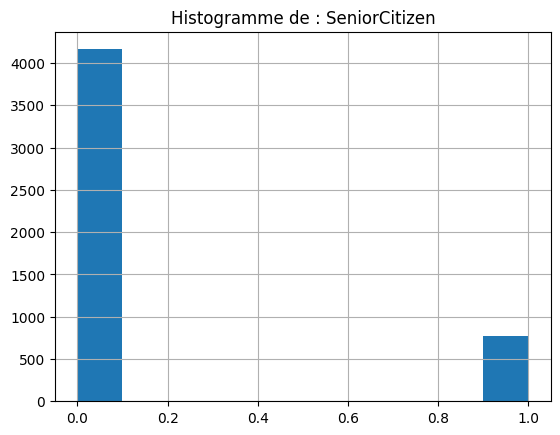

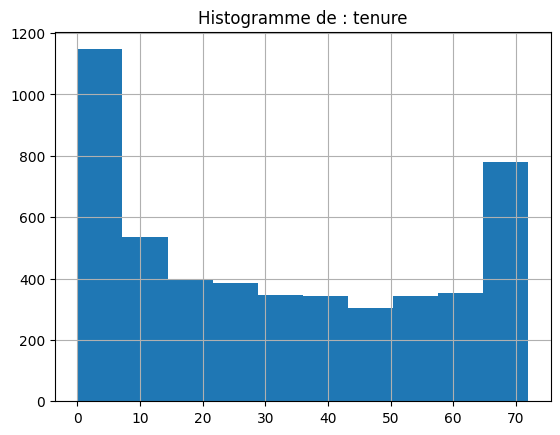

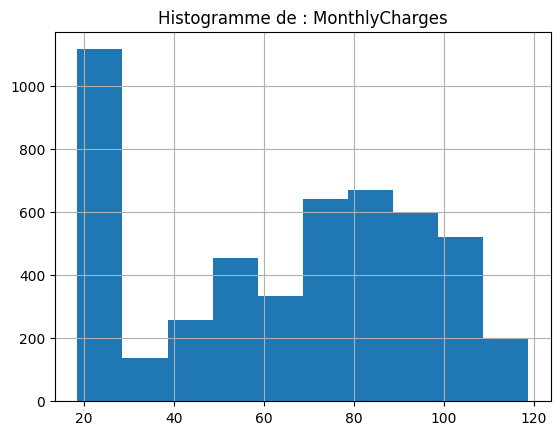

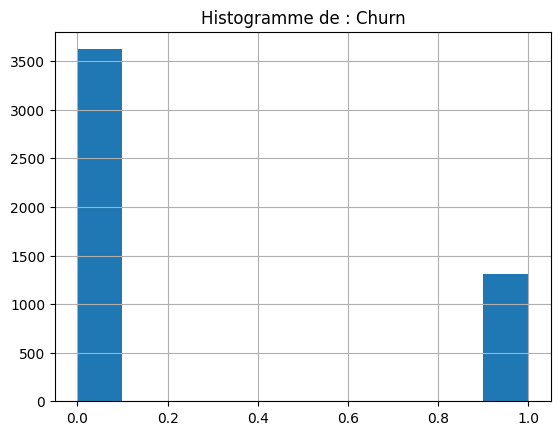

In [24]:
# Histogramme de chaque variable quantitative
for col in quant_cols:
    train_copy[col].hist()
    plt.title("Histogramme de : " + col)
    plt.show()
    plt.close()

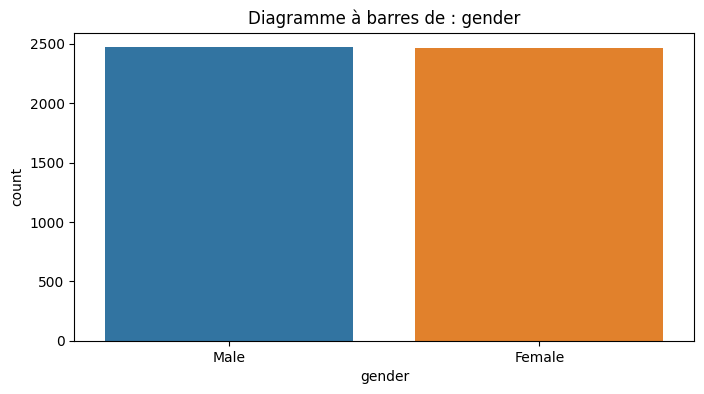

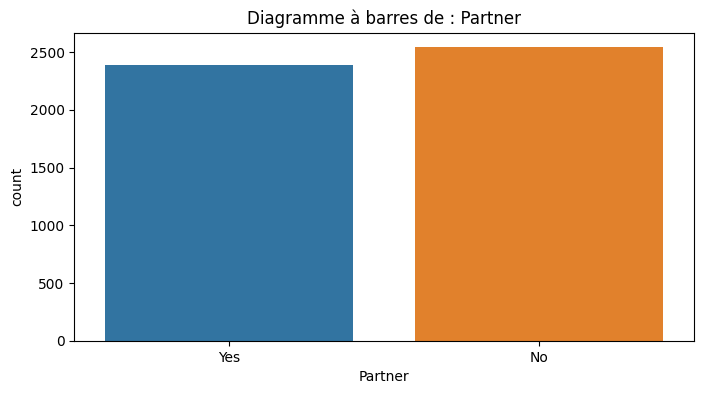

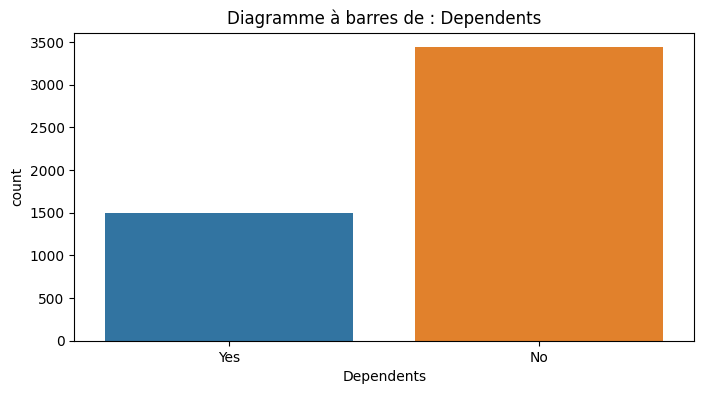

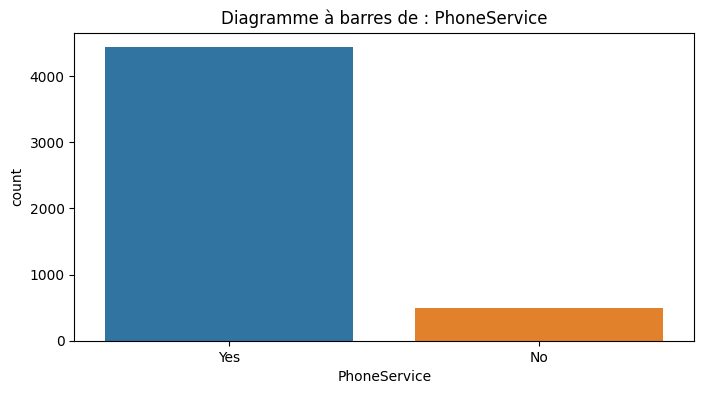

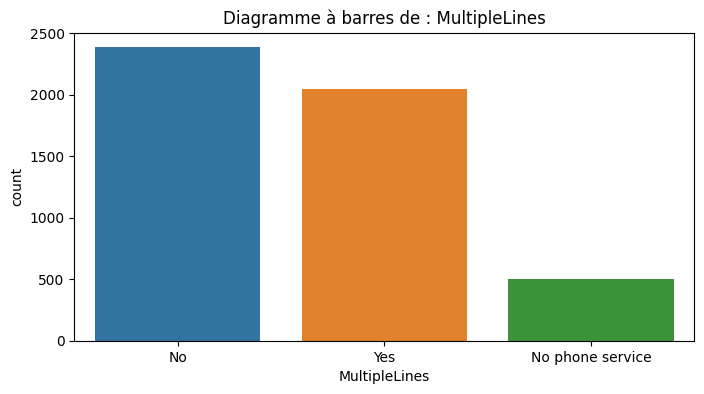

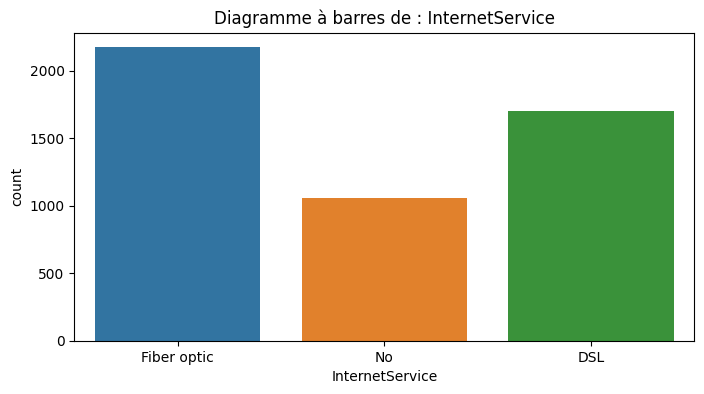

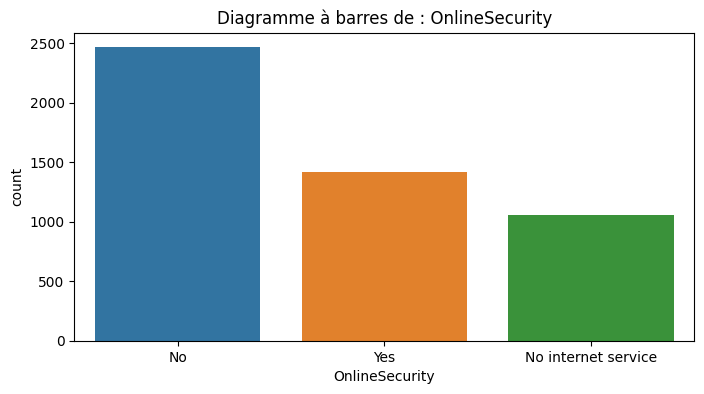

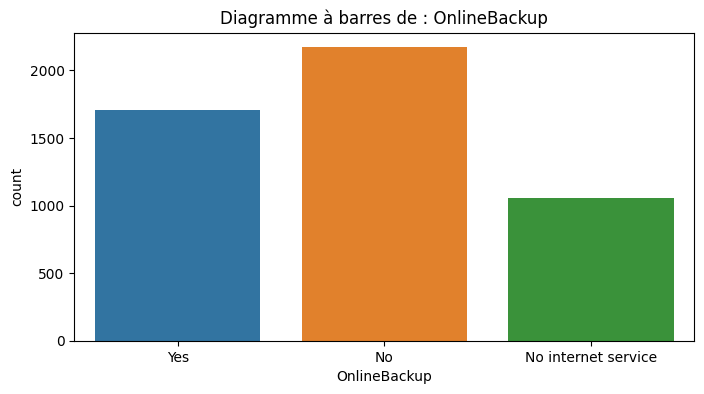

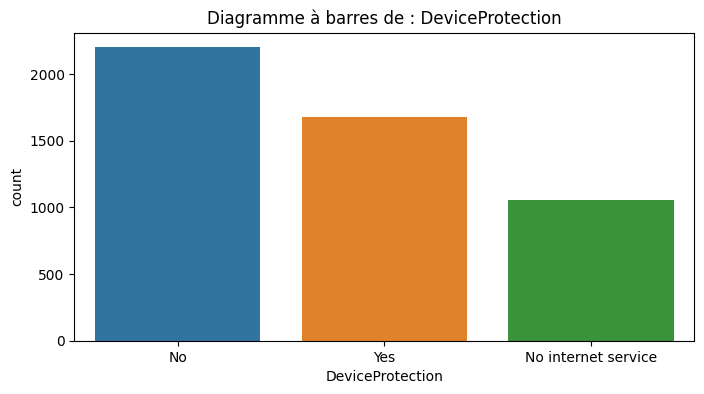

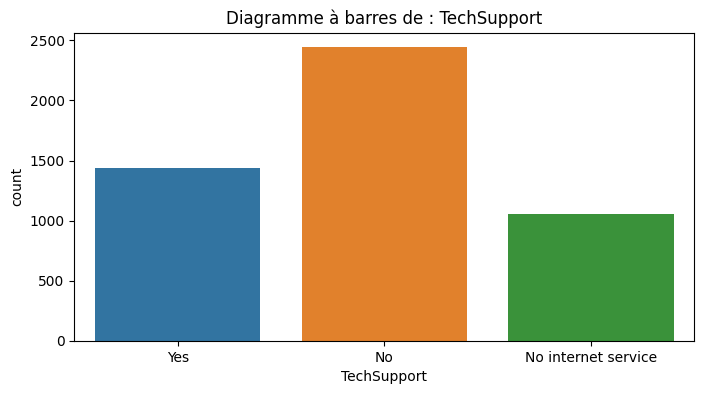

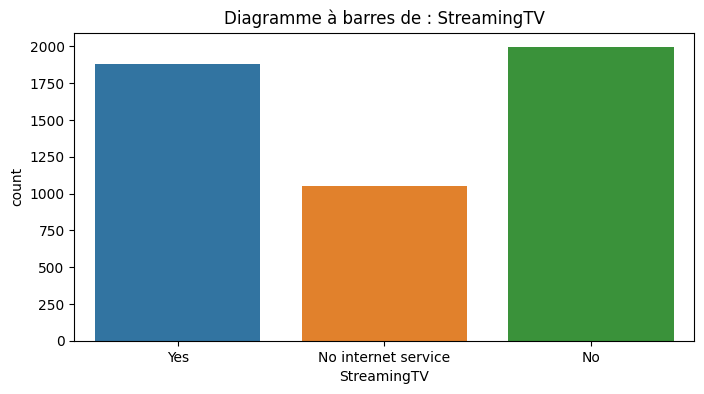

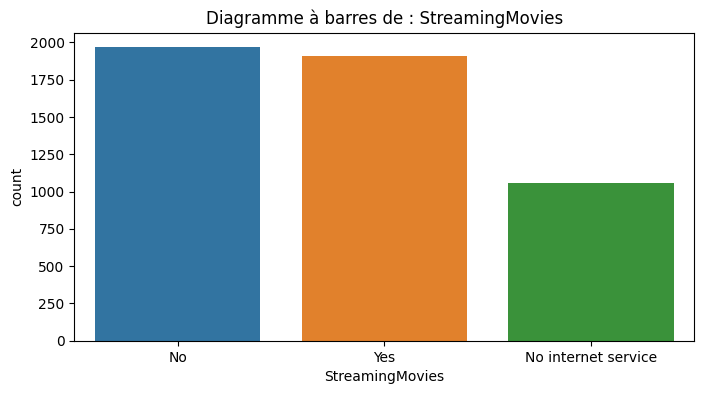

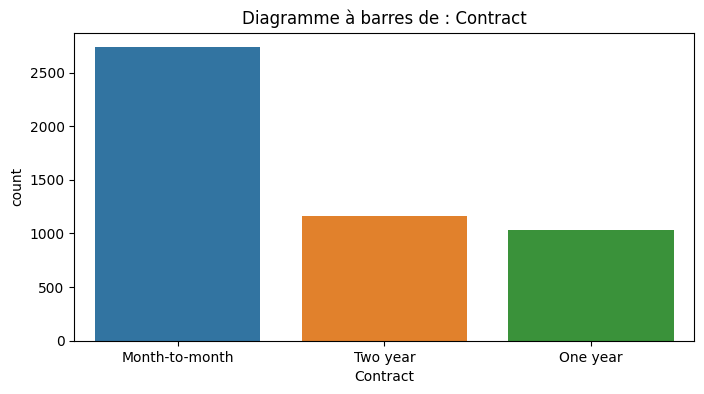

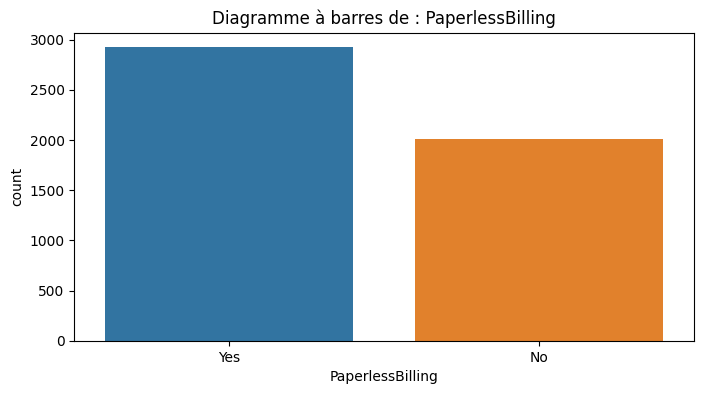

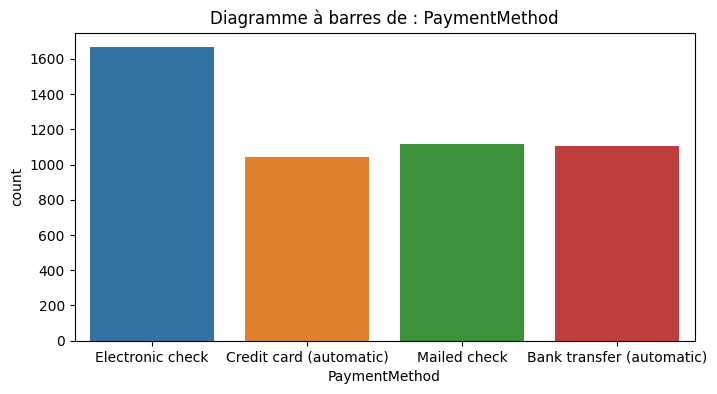

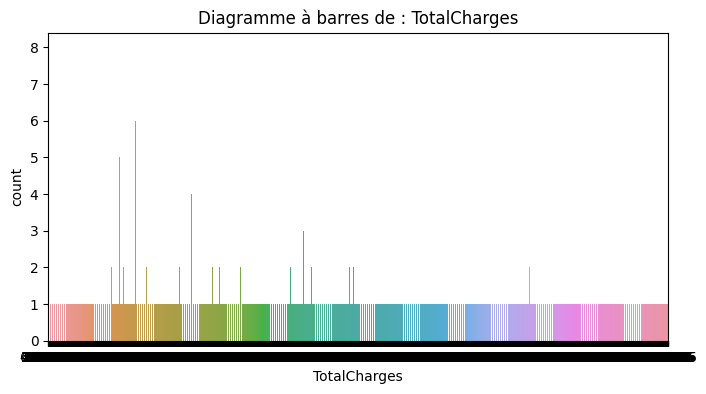

In [25]:
# Diagramme à barres de chaque variable qualitative
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=train_copy, x=col)
    plt.title("Diagramme à barres de : " + col)
    plt.show()
    plt.close()

In [26]:
train_copy['TotalCharges']

4890    4779.45
511     6300.15
169       321.4
3649    1847.55
1568    1183.05
         ...   
3194     2342.2
4935    1174.35
6883     3688.6
2711    2598.95
5298    6401.25
Name: TotalCharges, Length: 4930, dtype: object

La variable *TotalCharges* est normalement une variable numérique. Si Pandas l'a considéré comme étant de type catégoriel c'est parce-que il y a certainement au moins une valeur non numérique au niveau de cette variable. Dans la partie consacrée au prétraitement des données, nous allons devoir régler ce problème.

In [27]:
# Matrice de corrélations
train_corr = train_copy.corr(numeric_only=True)
train_corr

,SeniorCitizen,tenure,MonthlyCharges,Churn
SeniorCitizen,1.000000,0.006503,0.224643,0.163730
tenure,0.006503,1.000000,0.241675,-0.354819
MonthlyCharges,0.224643,0.241675,1.000000,0.193961
Churn,0.163730,-0.354819,0.193961,1.000000


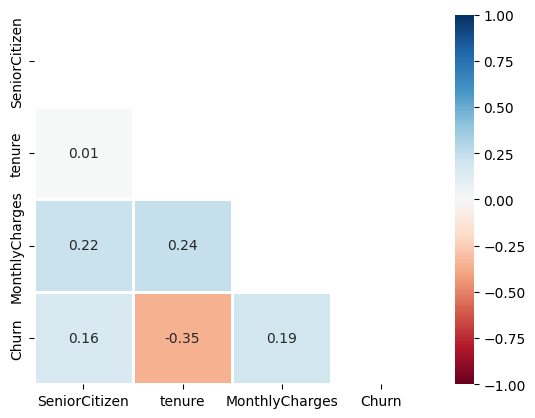

In [28]:
# Carte des corrélations
sns.heatmap(
    train_corr,
    mask=np.triu(np.ones_like(train_corr, dtype=bool)),
    center=0, cmap='RdBu', linewidths=1, annot=True,
    fmt=".2f", vmin=-1, vmax=1
)
plt.show()
plt.close()

## Prétraitement des données

Le prétraitement des données consistera à gérer les valeurs manquantes, à encoder les variables catégorielles et à standardiser les variables quantitatives. 

Commençons d'abord par voir ce qui se passe au niveau de la variable *TotalCharges*.

In [29]:
# Forcer la conversion de la variable 'TotalCharges'
# Les variables qui ne seront pas converties seront transformées en valeurs manquantes
total_charges = pd.to_numeric(train_copy['TotalCharges'], errors='coerce')
total_charges.isna().sum()

8

In [31]:
# Valeurs qui posent problème
train_copy[total_charges.isna()]['TotalCharges'].unique()

array([' '], dtype=object)

Ce sont donc les espaces ' ' qui causaient problème au niveau de la variable *TotalCharges*.

Créons maintenant un pipeline pour le prétraitement des données avant la phase de modélisation.

In [39]:
# Fonction pour régler le problème de la colonne 'TotalCharges'
def convert_totalcharges(X):
    # X : dataframe
    Z = X.copy()
    Z['TotalCharges'] = pd.to_numeric(Z['TotalCharges'], errors='coerce')
    return Z.values

Le pipeline de prétraitement des données doit comporter :

* une étape pour convertir la variable 'TotalCharges' en variable numérique ;

* une étape pour gérer les valeurs manquantes de la variable 'TotalCharges' ;

* une étape pour standardiser les variables indépendantes (*features*) numériques ;

* une étape pour encoder les variables indépendantes qualitatives.

Pour commencer, créons une liste des variables indépendantes numériques et une autre liste des variables indépendantes qualitatives :

In [34]:
quant_cols

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Churn']

In [35]:
numeric_features = quant_cols[:-1] + ['TotalCharges']
numeric_features

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [36]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'TotalCharges']

In [37]:
categorical_features = cat_cols[:-1]
categorical_features

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [40]:
# Pipeline de prétraitement des variables indépendantes numériques
numeric_transformer = Pipeline(
    steps= [('convert', FunctionTransformer(convert_totalcharges)), 
            ('imputer', SimpleImputer(strategy='median')), 
            ('scaler', StandardScaler())]
)

# Pipeline de prétraitement des variables indépendantes qualitatives
categorical_transformer = Pipeline(
    steps=[('onehotencoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))]
)

# Combinaison des deux précédents pipelines en un seul
preprocessor = ColumnTransformer(
    transformers=[('numeric', numeric_transformer, numeric_features),
                  ('categorical', categorical_transformer, categorical_features)]
)

print(preprocessor)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('convert',
                                                  FunctionTransformer(func=<function convert_totalcharges at 0x000001AA67D880D0>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['SeniorCitizen', 'tenure', 'MonthlyCharges',
                                  'TotalCharges']),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['gender', 'Partner', 'Dependents',
                                  'PhoneSer

In [41]:
# Image du pipeline de prétraitement
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('convert',
                                                  FunctionTransformer(func=<function convert_totalcharges at 0x000001AA67D880D0>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['SeniorCitizen', 'tenure', 'MonthlyCharges',
                                  'TotalCharges']),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['gender', 'Partner', 'Dependents',
                                  'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod'])])

## Modélisation

In [42]:
# Construction du pipeline de modélisation avec l'algorithme des Forêts aléatoire comme estimateur

rf_pipe_model = Pipeline(
    steps=[('preprocessor', preprocessor), 
           ('rf', RandomForestClassifier(random_state=seed))]
)

rf_pipe_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('convert',
                                                                   FunctionTransformer(func=<function convert_totalcharges at 0x000001AA67D880D0>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categorical',
                                                  Pipeline(steps=[('on...encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('rf', RandomForestClassifier(random_state=123))])

In [43]:
# Construction du pipeline de modélisation avec l'algorithme de régression logistique comme estimateur

logreg_pipe_model = Pipeline(
    steps=[('preprocessor', preprocessor), 
           ('logreg', LogisticRegression(random_state=seed, max_iter=2000))]
)

logreg_pipe_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('convert',
                                                                   FunctionTransformer(func=<function convert_totalcharges at 0x000001AA67D880D0>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categorical',
                                                  Pipeline(steps=[('on...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('logreg',
                 LogisticRegression(max_iter=2000, random_state=123))])

In [44]:
X_train, X_val, y_train, y_val = train.drop('Churn', axis=1), validate.drop('Churn', axis=1), train['Churn'], validate['Churn']
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, '\n')

(4930, 19) (4930,) (1057, 19) (1057,) 



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3622
           1       1.00      1.00      1.00      1308

    accuracy                           1.00      4930
   macro avg       1.00      1.00      1.00      4930
weighted avg       1.00      1.00      1.00      4930



              precision    recall  f1-score   support

           0       0.81      0.89      0.85       776
           1       0.59      0.43      0.50       281

    accuracy                           0.77      1057
   macro avg       0.70      0.66      0.67      1057
weighted avg       0.75      0.77      0.76      1057



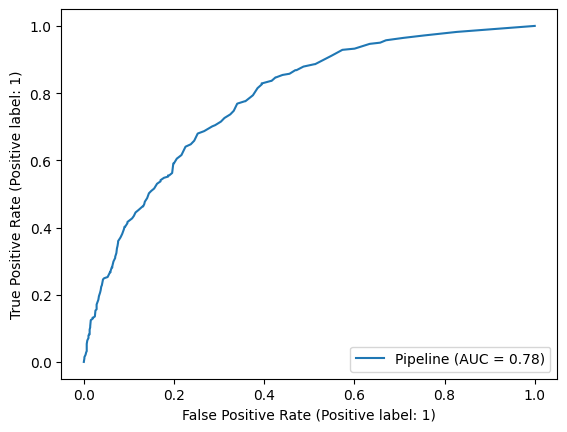

In [45]:
# Formation du modèle de forêt aléatoire
rf_pipe_model.fit(X_train, y_train)

# Prédictions sur les données d'entrainement
y_train_preds_rf = rf_pipe_model.predict(X_train)

# Prédictions sur les données de validation
y_val_preds_rf = rf_pipe_model.predict(X_val)

# Rapports de classification
print(classification_report(y_train, y_train_preds_rf))
print('\n')
print(classification_report(y_val, y_val_preds_rf))

# Courbe ROC
rf_roc = RocCurveDisplay.from_estimator(rf_pipe_model, X_val, y_val)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3622
           1       0.66      0.55      0.60      1308

    accuracy                           0.80      4930
   macro avg       0.75      0.72      0.74      4930
weighted avg       0.80      0.80      0.80      4930



              precision    recall  f1-score   support

           0       0.83      0.89      0.86       776
           1       0.62      0.48      0.54       281

    accuracy                           0.78      1057
   macro avg       0.72      0.69      0.70      1057
weighted avg       0.77      0.78      0.77      1057



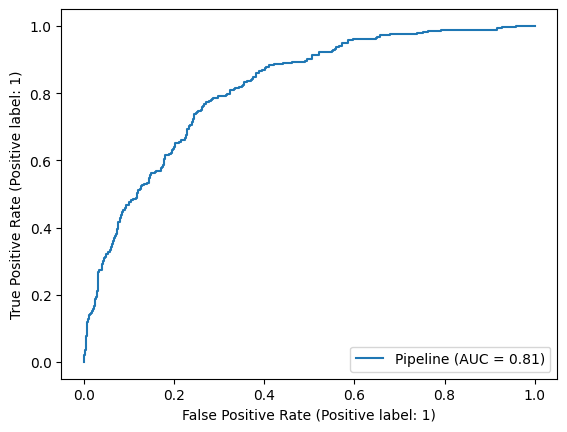

In [46]:
# Formation du modèle de régression logistique
logreg_pipe_model.fit(X_train, y_train)

# Prédictions sur les données d'entrainement
y_train_preds_logreg = logreg_pipe_model.predict(X_train)

# Prédictions sur les données de validation
y_val_preds_logreg = logreg_pipe_model.predict(X_val)

# Rapports de classification
print(classification_report(y_train, y_train_preds_logreg))
print('\n')
print(classification_report(y_val, y_val_preds_logreg))

# Courbe ROC
logreg_roc = RocCurveDisplay.from_estimator(logreg_pipe_model, X_val, y_val)

D'après les résultats ci-dessous, le modèle de régression logistique est meilleur que celui de forêts aléatoire. Nous allons procéder au réglage des hyperparamètres de ce modèle :

## Réglage des hyperparamètres du modèle

In [47]:
# Réglage des hyperparamètres du modèle de régression logistique

pipeline_model = Pipeline(
    steps=[('preprocessor', preprocessor), 
           ('logreg', LogisticRegression(random_state=seed, max_iter=2000))]
)

param_grid = {
    'logreg__solver' : ['lbfgs', 'saga', 'sag', 'newton-cg', 'newton-cholesky'],
    'logreg__penalty' : ['l2', None],
    'logreg__C' : [0.5, 1.0, 5.0, 10.0]
}

search_model = GridSearchCV(
    estimator=pipeline_model, 
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

search_model.fit(X_train, y_train)

print(search_model.best_params_)

print(search_model.best_score_)

{'logreg__C': 5.0, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}
0.8443050118043238


In [48]:
# Enregistrement du meilleur modèle
joblib.dump(search_model.best_estimator_, './models/best_model.pkl')

['./models/best_model.pkl']

## Analyse de la performance du meilleur modèle sur les données de test

In [49]:
# Chargement du meilleur modèle
loaded_model = joblib.load('./models/best_model.pkl')
loaded_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('convert',
                                                                   FunctionTransformer(func=<function convert_totalcharges at 0x000001AA67D880D0>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categorical',
                                                  Pipeline(steps=[('on...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('logreg',
                 LogisticRegression(C=5.0, max_iter=2000, random_state=123,
                                    solver='newton-cg'))])

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       776
           1       0.71      0.59      0.64       280

    accuracy                           0.83      1056
   macro avg       0.78      0.75      0.76      1056
weighted avg       0.82      0.83      0.82      1056



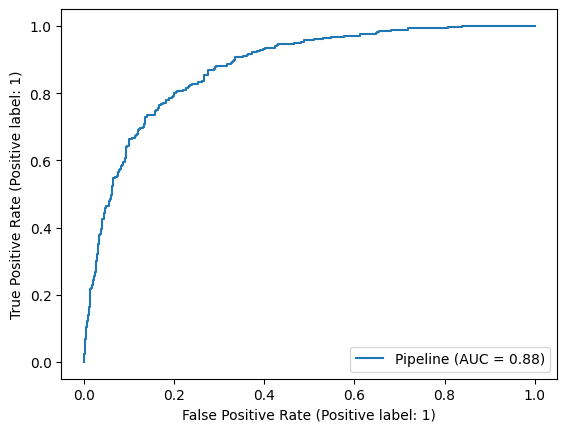

In [50]:
# Prédictions sur les données de test
X_test, y_test = test.drop('Churn', axis=1), test['Churn']
y_test_preds = loaded_model.predict(X_test)

# Rapport de classification
print(classification_report(y_test, y_test_preds))

# Courbe ROC
roc_plot = RocCurveDisplay.from_estimator(loaded_model, X_test, y_test)

**Qualité du code :**

autopep8 --in-place --aggressive --aggressive churn_library.py

pylint churn_library.py

In [ ]:
#pip install autopep8